In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Adiciona o caminho da raiz do projeto (BINARYCLASSIFICATION) ao sys.path
sys.path.append(os.path.abspath(".."))


In [108]:
df = pd.read_csv("../data/class_imbalance/dataset_38_sick.csv")

In [109]:
print(df.head())

    age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41.0   F            f                  f                         f    f   
1  23.0   F            f                  f                         f    f   
2  46.0   M            f                  f                         f    f   
3  70.0   F            t                  f                         f    f   
4  70.0   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... TT4_measured  \
0        f               f              f                 f  ...            t   
1        f               f              f                 f  ...            t   
2        f               f              f                 f  ...            t   
3        f               f              f                 f  ...            t   
4        f               f              f                 f  ...            t   

     TT4 T4U_measured   T4U FTI_measured    

In [110]:
print(df.value_counts(df.columns[-1]))

Class
negative    3541
sick         231
Name: count, dtype: int64


In [111]:
df["Class"] = df["Class"].map({"negative": 0, "sick": 1})


In [112]:
binary_map = {"t": 1, "f": 0, "M": 1, "F": 0}
df = df.replace(binary_map)


/tmp/ipykernel_34929/812959018.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


In [113]:
df = df.replace("?", np.nan)

In [114]:
df = df.drop(columns=["referral_source"])


In [115]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object', 'bool']).columns

# Preenche colunas numéricas com a média
for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())

# Preenche colunas categóricas com a moda (linha por linha, seguro)
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        moda = df[col].mode()
        if not moda.empty:
            df[col] = df[col].fillna(moda.iloc[0])


In [116]:
print("Valores ausentes restantes:", df.isnull().sum().sum())


Valores ausentes restantes: 3772


In [117]:
print(df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))


TBG    3772
dtype: int64


In [118]:
df = df.drop(columns=["TBG"])


In [119]:
X = df.drop("Class", axis=1).values
y = df["Class"].values


In [120]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # mantém proporção das classes
)




In [121]:
from src.BCE_Logistic_regression import LogisticRegression

# Treinamento com BCE
model_bce = LogisticRegression(lr=0.001, tolerance=1e-6, max_iters=1000)
model_bce.fit(X_train, y_train)

# Previsões de probabilidade no conjunto de teste
probs = model_bce.predict_proba(X_test)

# Inspeção das saídas
print("Probabilidades previstas (amostra):", probs[:10])
print("Min/Max das probabilidades:", np.min(probs), np.max(probs))

# Salvando erros para comparar modelos 
errors_bce = model_bce.errors

Probabilidades previstas (amostra): [0.11764714 0.03538682 0.02155967 0.0430341  0.15283494 0.00249194
 0.08549386 0.00163438 0.07423849 0.04503878]
Min/Max das probabilidades: 9.071951395029121e-07 0.5435107805742738


In [122]:
"""
### Situação e Interpretação de probabilidade no conjunto de teste

- **Todas as probs perto de 0**  
    O modelo só prevê a classe 0 (underfitting ou classe dominante).

- **Todas as probs perto de 1**  
    O modelo só prevê a classe 1 (mesmo problema invertido).

- **Todas as probs em torno de 0.5**  
    O modelo não aprendeu nada útil (provável má inicialização ou erro de loss).

- **Probs bem distribuídas (entre 0.1 e 0.9)**  
    Bom sinal de que está aprendendo
"""

'\n### Situação e Interpretação de probabilidade no conjunto de teste\n\n- **Todas as probs perto de 0**  \n    O modelo só prevê a classe 0 (underfitting ou classe dominante).\n\n- **Todas as probs perto de 1**  \n    O modelo só prevê a classe 1 (mesmo problema invertido).\n\n- **Todas as probs em torno de 0.5**  \n    O modelo não aprendeu nada útil (provável má inicialização ou erro de loss).\n\n- **Probs bem distribuídas (entre 0.1 e 0.9)**  \n    Bom sinal de que está aprendendo\n'

In [123]:
y_pred = model_bce.predict(X_test)
print("BCE Model")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))



BCE Model
Acurácia: 0.9364238410596026
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
Matriz de Confusão:
[[707   2]
 [ 46   0]]


In [124]:
## Teste com nova funcao de custo
# Isso garante que qualquer alteração feita entre em vigor sem reiniciar o kernel.
import src.Focal_Loss_Logistic_Regression  # importa o módulo base
importlib.reload(src.Focal_Loss_Logistic_Regression)  # força recarregamento

from src.Focal_Loss_Logistic_Regression import LogisticRegression

In [125]:
from sklearn.metrics import f1_score
from itertools import product

# Parâmetros do Grid Search
gamma_values = [2.5, 3.0, 3.5, 4.0]
alpha_values = [0.1, 0.2, 0.25, 0.3]

best_f1 = 0
best_params = {}

# Grid Search
for alpha, gamma in product(alpha_values, gamma_values):
    model = LogisticRegression(lr=0.01, max_iters=1000, alpha=alpha, gamma=gamma)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    print(f"Alpha: {alpha}, Gamma: {gamma} -> F1-score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_params = {'alpha': alpha, 'gamma': gamma}

print("\nMelhores parâmetros:")
print(f"Alpha: {best_params['alpha']}, Gamma: {best_params['gamma']}, F1-score: {best_f1:.4f}")


Convergência alcançada em 1 iterações.
Alpha: 0.1, Gamma: 2.5 -> F1-score: 0.3218


Convergência alcançada em 40 iterações.
Alpha: 0.1, Gamma: 3.0 -> F1-score: 0.3495
Alpha: 0.1, Gamma: 3.5 -> F1-score: 0.0000
Alpha: 0.1, Gamma: 4.0 -> F1-score: 0.0000
Convergência alcançada em 6 iterações.
Alpha: 0.2, Gamma: 2.5 -> F1-score: 0.0000
Convergência alcançada em 200 iterações.
Alpha: 0.2, Gamma: 3.0 -> F1-score: 0.3789
Convergência alcançada em 1 iterações.
Alpha: 0.2, Gamma: 3.5 -> F1-score: 0.0000
Convergência alcançada em 170 iterações.
Alpha: 0.2, Gamma: 4.0 -> F1-score: 0.3670
Convergência alcançada em 587 iterações.
Alpha: 0.25, Gamma: 2.5 -> F1-score: 0.3654
Convergência alcançada em 1 iterações.
Alpha: 0.25, Gamma: 3.0 -> F1-score: 0.0000
Convergência alcançada em 11 iterações.
Alpha: 0.25, Gamma: 3.5 -> F1-score: 0.0000
Convergência alcançada em 2 iterações.
Alpha: 0.25, Gamma: 4.0 -> F1-score: 0.0000
Convergência alcançada em 17 iterações.
Alpha: 0.3, Gamma: 2.5 -> F1-score: 0.0000
Convergência alcançada em 496 iterações.
Alpha: 0.3, Gamma: 3.0 -> F1-score: 0.30

In [126]:
model_focal = LogisticRegression(lr=0.001, tolerance=1e-6, max_iters=1000, alpha=best_params['alpha'], gamma=best_params['gamma'])
model_focal.fit(X_train, y_train)

Convergência alcançada em 161 iterações.


In [127]:
y_pred = model_focal.predict(X_test)
print("Focal Loss Model")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))



Focal Loss Model
Acurácia: 0.937748344370861
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
Matriz de Confusão:
[[708   1]
 [ 46   0]]


In [128]:
## Teste com nova funcao de custo
# Isso garante que qualquer alteração feita entre em vigor sem reiniciar o kernel.
import src.Weighted_BCE_Logistic_regression  # importa o módulo base
importlib.reload(src.Weighted_BCE_Logistic_regression)  # força recarregamento

from src.Weighted_BCE_Logistic_regression import LogisticRegression

In [129]:
model_weighted = LogisticRegression(lr=0.001, max_iters=1000)
model_weighted.fit(X_train, y_train)

y_pred = model_weighted.predict(X_test)
print("Weighted BCE Model")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

Weighted BCE Model
Acurácia: 0.9364238410596026
Precisão: 0.45
Recall: 0.1956521739130435
F1-score: 0.2727272727272727
Matriz de Confusão:
[[698  11]
 [ 37   9]]


In [130]:
## Teste com nova funcao de custo
# Isso garante que qualquer alteração feita entre em vigor sem reiniciar o kernel.
from src.Weighted_BCE_Logistic_regression_New_Sigmoid import LogisticRegression


In [131]:
from itertools import product
from sklearn.metrics import f1_score

# Hiperparâmetros para o Grid Search
temperatures = [1.0, 1.5, 1.8, 2.0]
thresholds = [0.3, 0.35, 0.4, 0.5]

best_f1 = 0
best_params = {}

# Grid Search
for temperature, threshold in product(temperatures, thresholds):
    model = LogisticRegression(
        lr=0.01, max_iters=1000, temperature=temperature, threshold=threshold
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    print(f"Temperature: {temperature}, Threshold: {threshold} -> F1-score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_params = {'temperature': temperature, 'threshold': threshold}

print("\nMelhores parâmetros:")
print(f"Temperature: {best_params['temperature']}, Threshold: {best_params['threshold']}, F1-score: {best_f1:.4f}")


Temperature: 1.0, Threshold: 0.3 -> F1-score: 0.1566
Convergência alcançada em 275 iterações.
Temperature: 1.0, Threshold: 0.35 -> F1-score: 0.1154
Temperature: 1.0, Threshold: 0.4 -> F1-score: 0.1550
Temperature: 1.0, Threshold: 0.5 -> F1-score: 0.1598
Temperature: 1.5, Threshold: 0.3 -> F1-score: 0.1538
Temperature: 1.5, Threshold: 0.35 -> F1-score: 0.3729
Temperature: 1.5, Threshold: 0.4 -> F1-score: 0.1556
Temperature: 1.5, Threshold: 0.5 -> F1-score: 0.1594
Temperature: 1.8, Threshold: 0.3 -> F1-score: 0.3729
Temperature: 1.8, Threshold: 0.35 -> F1-score: 0.1507
Temperature: 1.8, Threshold: 0.4 -> F1-score: 0.3423
Temperature: 1.8, Threshold: 0.5 -> F1-score: 0.1532
Temperature: 2.0, Threshold: 0.3 -> F1-score: 0.1502
Temperature: 2.0, Threshold: 0.35 -> F1-score: 0.1479
Temperature: 2.0, Threshold: 0.4 -> F1-score: 0.1501
Temperature: 2.0, Threshold: 0.5 -> F1-score: 0.1518

Melhores parâmetros:
Temperature: 1.5, Threshold: 0.35, F1-score: 0.3729


In [132]:
model_weighted_newSigmoid = LogisticRegression(lr=0.01, tolerance=1e-6, max_iters=1000, temperature=best_params['temperature'], threshold=best_params['threshold'])
model_weighted_newSigmoid.fit(X_train, y_train)

y_pred = model_weighted_newSigmoid.predict(X_test)
print("Weighted BCE Model New Sigma")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

Weighted BCE Model New Sigma
Acurácia: 0.42119205298013246
Precisão: 0.08492569002123142
Recall: 0.8695652173913043
F1-score: 0.15473887814313347
Matriz de Confusão:
[[278 431]
 [  6  40]]


In [133]:
## Teste com nova funcao de custo
# Isso garante que qualquer alteração feita entre em vigor sem reiniciar o kernel.
from src.BCE_Logistic_Sigmoid import BCE_Logistic_Sigmoid

model_bce_sig = BCE_Logistic_Sigmoid(lr=0.001, max_iters=1000, temperature=1.0)
model_bce_sig.fit(X_train, y_train)

y_pred = model_bce_sig.predict(X_test)
print("BCE Sigmoid Model")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


BCE Sigmoid Model
Acurácia: 0.9364238410596026
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
Matriz de Confusão:
[[707   2]
 [ 46   0]]


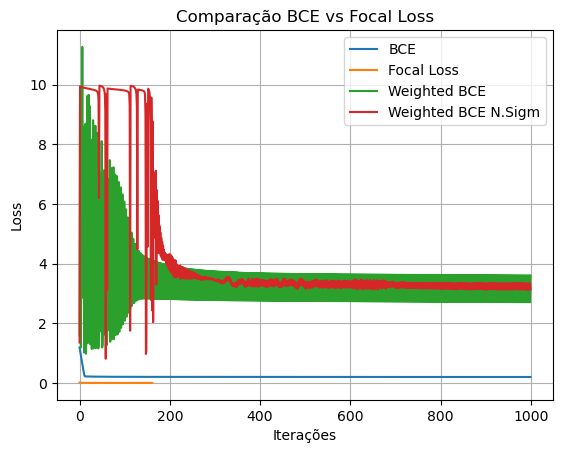

In [134]:
#Comparacao grafica dos erros dos modelos

plt.plot(model_bce.errors, label="BCE")
plt.plot(model_focal.errors, label="Focal Loss")
plt.plot(model_weighted.errors, label="Weighted BCE")
plt.plot(model_weighted_newSigmoid.errors, label="Weighted BCE N.Sigm")
plt.xlabel("Iterações")
plt.ylabel("Loss")
plt.title("Comparação BCE vs Focal Loss")
plt.legend()
plt.grid(True)
plt.show()



| Modelo        | Acuracia | Precisão | Recall | F1-score | Predição de classe 1? | Comentários                             |
|---------------|----------|----------|--------|----------|-----------------------|-----------------------------------------|
| BCE (padrão)  | 0.9364   | 0.00     | 0.00   | 0.00     | Nunca                 | Totalmente enviesado para classe 0      |
| BCE (Novo Sigmoid)  | 0.9364   | 0.00     | 0.00   | 0.00     | Nunca                 | Totalmente enviesado para classe 0      |
| Focal Loss    | 0.9377   | 0.00     | 0.00   | 0.00     | Nunca                 | Mesmo problema —                        |
| Weighted BCE  | 0.4198   | 0.08     | 0.84   | 0.15     | Sim                   | aprendeu algo sobre a classe 1          |
| Weighted BCE New Sig  | 0.9033   | 0.29     | 0.41   | 0.34     | Sim                   | aprendeu algo sobre a classe 1          |

In [ ]:
from src.cross_validation import kfold_cross_validate, summarise_metrics
from src.Weighted_BCE_Logistic_regression import LogisticRegression as WeightedLR
cv_metrics = kfold_cross_validate(WeightedLR, X, y, k=5, lr=0.001, max_iters=1000)
print(summarise_metrics(cv_metrics))